In [1]:
#import utils
import sys
import pathlib
import Bio
import pydna
import pydna.dseqrecord
import pydna.amplify
import pydna.gel
import pydna.ladders
import pydna.assembly
import IPython.core.display
import IPython.display

import pydna.editor

from Bio import SeqIO
# import constrain modules

# Project

Debottlenecking the strictosidine module

Hypothesis
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

Tasks
1. dgRNA 
2. **Base strain**
    - From de novo producer (MIA-CM-3)
    - MIA-HA-1 (MIA-CM-3 -CroCPR - CroG8H)
3. Library
4. Phenotyping
5. Data analysis

# Base strain

MIA-CM-3

In [2]:
sys.path.append('../constrain/lims')

from benchling_api import from_benchling

In [3]:

CM3 = SeqIO.read("../data/raw/CENPK113-7d/11.fa", "fasta")
CM3

SeqRecord(seq=Seq('CACCACACACACCACACACCACACCCACACACACACCACACCCACACACCACAC...ATT'), id='CEN.PK113-7d_11', name='CEN.PK113-7d_11', description='CEN.PK113-7d_11 Saccharomyces cerevisiae CEN.PK113-7D chromosome XI, whole genome shotgun sequence.', dbxrefs=[])

In [4]:
G8H_template_names = ["pESC-CEN_RS-OeuG8H","PL_10_A1pMIA_JZ-40_CroG8H","pMIA_086_Rsep_G8O_in_p0057_(TRP)","pMIA_087_Vmin_G8O_in_p0057_(TRP)","pMIA_088_Opum_G8O_in_p0057_(TRP)","pMIA_089_Cacu_G8O_in_p0057_(TRP)","pMIA_090_Smus_G8O_in_p0057_(TRP)","pMIA_091_Ccal_G8O_in_p0057_(TRP)"]
pG8H_template_names = ['pCYC1','pENO2','pPCK1','pRPL15B']


CPR_template_names = ["pMIA_042_Cro_CPR_in_pRS415_USER_(leu)_-_TEF1","pMIA_048_(G2_Aan_CPR_(TEF1)_in_pRS415U_(LEU))","pMIA_055_ATR1_in_pRS415_USER_(leu)_-_TEF1","PL_13_E6_(pRS415U-P2_TEF1-CloCPR_opt2)","PL_13_E7_(pRS415U-P2_TEF1-RseCPR_opt2)","PL_13_E8_(pRS415U-P2_TEF1-AhuCPR_opt2)","PL_13_E9_(pRS415U-P2_TEF1-AniCPR_opt2)","PL_13_F1_(pRS415U-P2_TEF1-CacCPR_opt2)","PL_13_F2_(pRS415U-P2_TEF1-OeuCPR_opt2)","PL_13_F3_(pRS415U-P2_TEF1-CpoCPR_opt2)"]
pCPR_template_names = ['pCCW12','pMLS1','pTPI1','pURE2']

marker_template_names = ["pL_01_E8_(pRS414-USER-ccdB)"]

pG8H_templates = [from_benchling(pname) for pname in pG8H_template_names]
G8H_templates = [from_benchling(tname) for tname in G8H_template_names]

CPR_templates = [from_benchling(tname) for tname in CPR_template_names]
pCPR_templates = [from_benchling(pname) for pname in pCPR_template_names]

marker_templates = [from_benchling(tname) for tname in marker_template_names]


AttributeError: 'NoneType' object has no attribute 'dump'

# dgRNA

In [5]:
gRNA_ATF1_CroCPR = from_benchling("pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)")

In [6]:
ATF1_gRNA = pydna.dseqrecord.Dseqrecord("GAATGGGCATGCTCGGCGTA", name = "ATF1")
CroCPR_gRNA = pydna.dseqrecord.Dseqrecord("GCCGTAGTAACGTCGCTGTC", name = "CroCPR") #CroCPR gRNA-2

# Repair templates

Repair templates: 
- G8H; tADH1-P1_PGK1_400
- CPR; XI-3 (l4_A08)

**G8H**

| Part | Template | Primer_Fw | Primer_Rv | Anneal | Size |
| --- | --- | --- | --- | --- | --- |
| tADH1-P1_PGK1_400 | pRS413U_P2_PGK1_mKate2 | pPGK1_Seq_Rv |USER_XhoI_Fw| Touchdown | 0.6 kb |

In [7]:
pRS413U_P2_PGK1_mKate2 = from_benchling("PL_02_E2(pRS413U-P2_PGK1-mKate2)")
pPGK1_Seq_Rv = from_benchling("pPGK1_Seq_Rv", 'Primer')
USER_XhoI_Fw = from_benchling("USER_XhoI_Fw", 'Primer')



In [8]:
ATF1_repair_template = pydna.amplify.pcr(pPGK1_Seq_Rv, USER_XhoI_Fw, pRS413U_P2_PGK1_mKate2)
ATF1_repair_template

Amplicon(659)

In [9]:
# Check annotations in clc
    # clc.open(ATF1_repair_template)
# Write function that can determine name from seqrecord features?
ATF1_repair_template.name = "tADH1-P1_PGK1_400"
# Use benchling API to find empty location, then create empty container with location
ATF1_repair_template.annotations['batches'] = [{'location':'l5_A02'}]
# Upload name, sequence to benchling
    # utils.to_benchling(ATF1_repair_template, "to_benchling", schema = 'DNA Fragment')

**CPR**

| Part | Template | Primer_Fw | Primer_Rv | Anneal | Size |
| --- | --- | --- | --- | --- | --- |
| XI-3 | gDNA | XI-3- up-out-sq |XI-3- down-out-sq| Touchdown | 1.4 kb |

In [10]:
# Create function to download PCR template
strain = "CENPK113-7d"
chromosome_no = "11"
PathToXIChromosomeSeq = "../data/raw/" + strain + "/" + str(chromosome_no).zfill(2) + ".fa"
XIChromosomeSeq      = Bio.SeqIO.read(PathToXIChromosomeSeq, "fasta")
XIChromosomeSeq.annotations['batches'] = []
XIChromosomeSeq.annotations['batches'].append({'location':"l4_A01"})

In [11]:
XI_3_up_out_sq = from_benchling("XI-3- up-out-sq", 'Primer')
XI_3_down_out_sq = from_benchling("XI-3- down-out-sq", 'Primer')
CPR_repair_template = pydna.amplify.pcr(XI_3_up_out_sq,XI_3_down_out_sq, XIChromosomeSeq)

In [12]:
SeqIO.write(XI_3_up_out_sq, "XI-3- up-out-sq.fasta", "fasta")
SeqIO.write(XI_3_down_out_sq, "XI-3- down-out-sq.fasta", "fasta")


1

In [13]:
CPR_repair_template.name = "XI-3"
CPR_repair_template.annotations['batches'] = [{'location':'l4_A08'}]

## PCR reactions

onetaq polymerase

In [14]:
sys.path.append('../constrain/lab')

from PCR import pcr_locations, pcr_volumes


In [15]:
pcr_locations([ATF1_repair_template, CPR_repair_template])

,location,name,template,fw,rv
0,PL02_e2,tADH1-P1_PGK1_400,PL02_e2,o3_a1,o3_e3
1,l4_A01,XI-3,l4_A01,o2_g4,o2_g5


In [16]:
pcr_volumes(vol_p_reac = 50, 
        no_of_reactions = 3,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])

,vol_p_reac,vol_p_3_reac
Template,1.0,3.0
Primer 1,2.5,7.5
Primer 2,2.5,7.5
H20,19.0,57.0
Pol,25.0,75.0
Total,50.0,150.0


In [17]:
# Insert code to determine thermocycler program
    #ATF1_repair_template.program()
    #CPR_repair_template.program()
    #Suggest program that allows both on one thermocycler

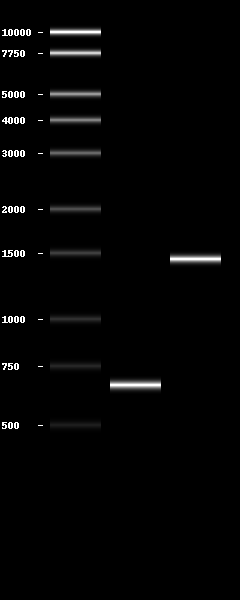

In [18]:
pydna.gel.gel([pydna.ladders.PennStateLadder,[ATF1_repair_template],[CPR_repair_template]]) #GeneRuler_1kb_; [Dseqrecord("A"*2000)]

For each PCR:
- Physically (eventually using robots):
    - Mix
    - Run thermocycler
    - Run gel
    - Determine purification method and elution volume
    - Purify
    - Measure concentration on nanodrop
    - Label container, transfer purified PCR to container, place container at given location.

For each PCR:
- Digitally (using benchlingapi):
    - Create a batch with concentration and volume and place in container

In [19]:
ATF1_repair_template.annotations['batches'][0].update({'volume'        : 10,
                                                       'concentration' : 50})
#utils.to_benchling(ATF1_repair_template, "to_benchling")

In [20]:
CPR_repair_template.annotations['batches'][0].update({'volume'        : 60,
                                                      'concentration' : 50})
#utils.to_benchling(CPR_repair_template, "to_benchling")

## Assemblies

| Name | Parent | gRNA (500 ng) | Parts (300 ng) |
| --- | --- | --- | --- |
| MIA-HA-1 | CM-3 | pESC-LEU-gRNA_ATF1-CroCPR | tADH1-P1_PGK1_400, XI-3 | 

In [21]:
parameters = {
'bg_strain': CM3,
'site_names': ["X-3", "XI-3"],
'gRNAs': [ATF1_gRNA, CroCPR_gRNA],
'parts': [[ATF1_repair_template],[CPR_repair_template]],
'assembly_limits':[200,400],
'assembly_names': ["X_3_tADH1_P2_pPGK1", "XI_3_UP_DW"],
'verbose': False,
'to_benchling': False  
}

In [22]:
sys.path.append('../constrain/design')

from cloning import casembler

In [23]:
# THIS function does not work atm 

HA1 = casembler(**parameters)

IndexError: list index out of range

In [24]:
# Create function
#XI_2 = utils.extract_sites(["XI-2"], [CM3],["XI-2"])[0]
#XI_2 = pydna.dseqrecord.Dseqrecord(XI_2)

#XI_2_feat = Bio.SeqFeature.SeqFeature(Bio.SeqFeature.FeatureLocation(0, len(XI_2), strand=1), type="misc_feature")
#XI_2_feat.qualifiers['name']="XI_2"
#XI_2_feat.qualifiers['label']="XI_2"
#XI_2.features.append(XI_2_feat)

In [25]:
#HA1 = "NN" + HA1 + XI_2 + "NN"

In [26]:
#HA1.name = "MIA-HA-1"

In [27]:
#HA1.annotations['batches'] = []
#HA1.annotations['batches'].append({'location':'y01_D08'})

In [28]:
#clc20.open(HA1)

In [29]:
#utils.to_benchling(CPR_repair_template, "to_benchling")

## Transformation reactions

Protocol for transformation:

In [30]:
IPython.display.FileLink('../methods/methods.ipynb')

/Users/lucaslevassor/projects/ConStrain/methods/methods.ipynb

In [31]:
sys.path.append('../constrain/lab')

from transformation import time_to_inculate, ng_to_nmol, transformation_mix

Assumed that: 
- transformation time 12 (reached OD=1 the day after)


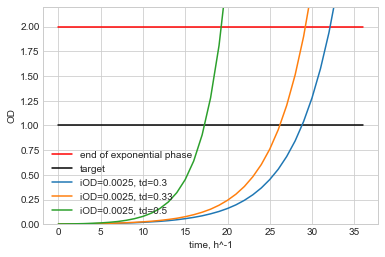

Hours to OD = 1: 	26 hours
Time of inoculation: 	9(the day before)

If you innoculate now, the cells will have reached OD= 1 by:   2022-08-31 19:56:23.901370


In [32]:
time_to_inculate(td=0.33)

import positive control

In [34]:
LEU_plasmid = from_benchling("pESC-LEU-gRNA_CroCPR-2")
#SeqIO.write(LEU_plasmid, "LEU_plasmid.fasta", "fasta")


In [35]:
HA1 = SeqIO.read('../data/raw/MIA-HA-1.gb','gb')

In [36]:
reaction_names = [HA1.name + "(MIA-CM-3 -CPR-G8H)", 
                  "n.ctr", "n.ctr", "n.ctr", "p. ctr"]

Parts needs equimolar 0.1 pmol = 0.0001 nmol

In [37]:
reaction_participants = [[gRNA_ATF1_CroCPR, ATF1_repair_template,CPR_repair_template],
                         [gRNA_ATF1_CroCPR],
                         [gRNA_ATF1_CroCPR, ATF1_repair_template],
                         [gRNA_ATF1_CroCPR, CPR_repair_template], 
                         [LEU_plasmid]]

500 ng gRNA_ATF1_CroCPR plasmid

In [38]:
nmol_gRNA = ng_to_nmol(ng = 500, bp = len(gRNA_ATF1_CroCPR))
nmol_gRNA

9.865727449413482e-05

10 ng LEU plasmid should be enough

In [39]:
nmol_pctr = ng_to_nmol(ng = 10, bp = len(LEU_plasmid))
nmol_pctr

2.248883991319308e-06

In [40]:
# in nmol
wanted_amounts = {'pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)' : nmol_gRNA,
                         'tADH1-P1_PGK1_400'                  : 0.0001,
                         'XI-3'                               : 0.0001,
                         'pMIA_042_Cro_CPR_in_pRS415_USER_(leu)_-_TEF1': nmol_pctr}

In [41]:
media = ['SC-LEU'] * 5

In [43]:
reaction_participants

[[SeqRecord(seq=Seq('TGGCGGGTGTCGGGGCTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAG...TGT'), id='seq_AA4vOQs1', name='pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)', description='<unknown description>', dbxrefs=[]),
  Amplicon(659),
  Amplicon(1449)],
 [SeqRecord(seq=Seq('TGGCGGGTGTCGGGGCTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAG...TGT'), id='seq_AA4vOQs1', name='pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)', description='<unknown description>', dbxrefs=[])],
 [SeqRecord(seq=Seq('TGGCGGGTGTCGGGGCTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAG...TGT'), id='seq_AA4vOQs1', name='pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)', description='<unknown description>', dbxrefs=[]),
  Amplicon(659)],
 [SeqRecord(seq=Seq('TGGCGGGTGTCGGGGCTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAG...TGT'), id='seq_AA4vOQs1', name='pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)', description='<unknown description>', dbxrefs=[]),
  Amplicon(1449)],
 [SeqRecord(seq=Seq('TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCTCCCGGAGA...GTC'), id='seq_Qy1hV9Gf', name='pESC-LEU-gRNA_CroCPR-2', des

In [42]:
transformation_mix(reaction_names, reaction_participants, wanted_amounts = wanted_amounts, water_dna_p_reac = 18.5, media = media)

TypeError: type str doesn't define __round__ method

In [ ]:
utils.volumes(vol_p_reac = 90, 
        no_of_reactions = 6,
        standard_reagents = ["PEG", "LiAc_1M", "ssDNA", "water_dna"],
        standard_volumes = [240, 36, 10, 74])

Expectation

In [ ]:
IPython.core.display.Image(utils.imagingStation / 'dgRNA ATF1 and CroCPR.jpg', width=600)

Actual

In [ ]:
IPython.core.display.Image(utils.imagingStation / '2021-02-09_transformation_plates.jpg', width=600)

Before transformation:
- MIA-CM-3 Doubling time is ~ 3h in YPD. WT is ~2h. This is also observed by Sam and Beata for MIA-CM-3.

After transformation:

1. Few colonies on all plates. This sometime happens with slow growing strains. Probably due to combination of cells less viable and generally less cells used for transformation. If we repeat, scale reaction to 360 µl, 5 ml OD 1 culture per transformation, 0.5 pmol DNA (repair templates), 500 ng gRNA

2. Few colonies on plate # 1: Worry that we do not see more colonies on plate # 1 compared to 2, 3,and 4. 
- Viability probably decreased by accumulation of toxic geraniol due to G8H knockout (see figure below) 
- I can't tell by any geraniol smell whether the knockout worked. 

Next step:
- Genotype all colonies on plate # 1. 
- If the plate#1 colonies are not correct we may switch to MIA-CH-A2. What do you think?

In [ ]:
# Strictosidine module
IPython.core.display.Image(utils.figures / 'Pathway.png', width=800)

## Genotyping

1. Pick 3 colonies from plate#1 and 1 colony from plate#5 
2. Yeast DNA extraction for PCR
3. Colony PCR

Protocol for HT Yeast DNA extraction for PCR

In [ ]:
IPython.display.FileLink('../references/methods.ipynb')

### 3. Colony PCR reactions

In [ ]:
sys.path.append('../constrain/lims')

from benchling_api import from_benchling

CroG8H

In [ ]:
CM3.features

In [ ]:
X_3_up_out_sq = from_benchling("X-3-up-out-sq", 'Primer')
pPGK1_Seq_Rv = from_benchling("pPGK1_Seq_Rv", 'Primer')
pTDH3_Seq_Rv = from_benchling("pTDH3_Seq_Rv", 'Primer')

In [ ]:
X_3_up_out_sq = from_benchling("PR_BII_01_B2 (X-3-up-out-sq)", 'Primer')
pPGK1_Seq_Rv = from_benchling("pPGK1_Seq_Rv", 'Primer')
pTDH3_Seq_Rv = from_benchling("PR_BII_02_E2 (pTDH3_Seq_Rv)", 'Primer')




In [ ]:
CM3.annotations['location'] = "unknown"
X_3 = utils.extract_sites(["X-3"], [CM3],["X-3"])[0]

In [ ]:
X_3.annotations['batches'] = []
X_3.annotations['batches'].append({'location': 'l4_A01'})

CroCPR

In [ ]:
outside_XI_3_ie_911 = utils.from_benchling("outside_XI-3_ie_911", 'Primer')
outside_XI_3_ie_912 = utils.from_benchling("outside_XI-3_ie_912", 'Primer')
CroCPR_U_Rv = utils.from_benchling("CroCPR_U_Rv", 'Primer')

In [ ]:
CM3.annotations['location'] = "unknown"
XI_3 = utils.extract_sites(["XI-3"], [CM3],["XI-3"])[0]
XI_3.annotations['batches'] = []
XI_3.annotations['batches'].append({'location': 'l4_A01'})

In [ ]:
# Trick to accomodate 3 primer PCR reactions
X_3_up_out_sq.annotations['batches'][0]['location']='o3_F06, PR_07_A3'
pTDH3_Seq_Rv.annotations['batches'][0]['location']='o3_F06, PR_07_A3'
outside_XI_3_ie_912.annotations['batches'][0]['location']='o3_D05, PR_05_A6'
CroCPR_U_Rv.annotations['batches'][0]['location']='o3_D05, PR_05_A6'

In [ ]:
G8H_1_1     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_2     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_3     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
CPR_1_1     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_2     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_3     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
nCtrG8H_5_1 = pydna.amplify.pcr(pTDH3_Seq_Rv, pPGK1_Seq_Rv, X_3) # G8H_no_ko_band
nCtrCPR_5_1 = pydna.amplify.pcr(outside_XI_3_ie_911, CroCPR_U_Rv, XI_3) # = CPR_no_ko_band 

In [ ]:
col_nos   = [1,2,3,1,2,3,1,1]
plate_nos = [1,1,1,1,1,1,5,5]
templates = [str(p_no) + "_" + str(c_no) for p_no, c_no in zip(plate_nos,col_nos)]

In [ ]:
descriptions = ["G8HKoBand"] * 3 + ["CPRKoBand"] * 3 + ['G8HnoKoBand'] + ['CPRnoKoBand']

In [ ]:
bands = [G8H_1_1, G8H_1_2, G8H_1_3, CPR_1_1, CPR_1_2, CPR_1_3] + [nCtrG8H_5_1, nCtrCPR_5_1]

In [ ]:
for band, desc, temp in zip(bands,descriptions, templates):
    band.name = desc + "-" + temp
    band.annotations['batches'] = [{'location':''}]
    band.annotations['template_location'] = temp

Explanation:

| | name | Template |
|---|---|---|
|#|name-template|colony # Y from 2021-02-02 plate # X, X_Y|

In [ ]:
#for band in bands:
#    print(type(band.template.annotations['batches'][0]))

In [ ]:
utils.pcr_locations1(bands)

PCR
- Polymerase: Onetaq (1min / kb) 
- Program: Touchdown
- Elongation time: 1.5 min
- Annealing temp 52/46

In [ ]:
utils.volumes(vol_p_reac = 20, 
        no_of_reactions = len(bands) + 1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [2.5, 2.5, 2.5, 19, 25])

In [ ]:
pydna.gel.gel([pydna.ladders.PennStateLadder,*[[band] for band in bands]]) #GeneRuler_1kb_

Actual gel

In [ ]:
IPython.core.display.Image(utils.bioimager / '2021-02-09 PCR_edited.jpg', width=300)

Colony no. 1 has CPR knockout band. CPR gRNA + repair template worked!.
Colony no. 4 has CPR noknockout band. 

No G8H bands. Why didn't G8H produce band for colony no.4 (well no. 7; negative control)?

Troubleshooting.
- template, polymerase, elongation time all worked for CPR

- Primers
    - primers sequences? 
        - Jie shown they work in MIA-CH-A2.
        - Redilute from stock!
- Program
    - primer annealing temperature?
        - 46/47 C (NEB). No unspecific bands. Decrease to 50/44
    - elongation time
        - Unlikely problem that 1.5 shouldn't work while 1.4 kb CPR band worked. But increase to 1:45 to make sure
- Template
    - Clear gDNA bands for all wells. Lower template volume to 0.4.
    - Try MIA-CM-3 gDNA from Beata. If works primers and program are off suspicion and only templates are in.

Additional comments:
- Run gel 5 min shorter time (~ 25 min) to lighten ~ 500 bp part of gel.

In [ ]:
nCtrG8H_Beata = pydna.amplify.pcr(pTDH3_Seq_Rv, pPGK1_Seq_Rv, X_3) # G8H_no_ko_band
nCtrG8H_Beata.name = "G8HnoKoBand" + "-" + "MIA-CM-3_Beata"
nCtrG8H_Beata.annotations['batches'] = [{'location':''}]
nCtrG8H_Beata.annotations['template_location'] = "MIA-CM-3_Beata"

In [ ]:
troubleshooting_bands = [G8H_1_1, G8H_1_2, G8H_1_3] + [nCtrG8H_5_1] + [nCtrG8H_Beata]
troubleshooting_bands

In [ ]:
utils.pcr_locations1(troubleshooting_bands)

PCR
- Polymerase: Onetaq (1min / kb) 
- Program: Touchdown
- Elongation time: 2 min
- Annealing temp 50/46

In [ ]:
utils.volumes(vol_p_reac = 20, 
        no_of_reactions = len(troubleshooting_bands) + 1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])

In [ ]:
pydna.gel.gel([pydna.ladders.PennStateLadder,*[[band] for band in troubleshooting_bands]]) #GeneRuler_1kb_

Actual gel

In [ ]:
IPython.core.display.Image(bioimager / '2021-02-10 ColPCR.jpg', width=300)

Observations:
- The G8H colony PCR is working
- Colony no. 4 and MIA-CM-3 gDNA from Beata now shows negative band
- Colony no. 3 shows weak knockout band!
- This means that our gRNA cutting and repair also worked for the G8H site aswell as for CPR!
- PCR still fails for colony no 1, and 2 (no "knockout" or "no knockout" bands)

Troubleshooting:
- primers, polymerase, program works

- template
    - Likely the problem. Improve template quality by reinoculating and using thermo fisher yeast dna extraction kit
    
- If too little repair template was added the strain may looped out the entire integration site in which case the primers can't bind and no band would be observed.
    - unlikely to happen for both integration sites

The combined results for our two colony PCR's are the following .
For colony #:
1. One CPR "knockout band"
3. One G8H "knockout band"
4. (Background strain i.e. ctrl) One G8H and one CPR "no knockout band".
- None of the three colonies has been confirmed to have "incorrect" genotype

Next steps:
1. Inoculate 6 colonies from plate # 1 (1-3 (the ones already used) + 3 colonies (hidden on the edge of the plate)) in 5 ml YPD
2. gDNA prep cultures using thermo fisher yeast dna extraction kit (and glycerol stock as you suggested)
3. Redo colony PCR with improved template quality and hopefully see all bands.

Protocol for thermo fisher yeast dna extraction kit

In [ ]:
IPython.display.FileLink('../references/MAN0011405_Yeast_DNA_Extract_Kit_UG.pdf')

In [ ]:
G8H_1_4     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_5     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_6     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
CPR_1_4     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_5     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_6     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
nCtrG8H_5_1 = pydna.amplify.pcr(pTDH3_Seq_Rv, pPGK1_Seq_Rv, X_3) # G8H_no_ko_band
nCtrCPR_5_1 = pydna.amplify.pcr(outside_XI_3_ie_911, CroCPR_U_Rv, XI_3) # = CPR_no_ko_band 

In [ ]:
col_nos   = [1,2,3,4,5,6,1,2,3,4,5,6,1,1]
plate_nos = [1,1,1,1,1,1, 1,1,1,1,1,1,5,5]
templates = [str(p_no) + "_" + str(c_no) for p_no, c_no in zip(plate_nos,col_nos)]

In [ ]:
descriptions = ["G8HKoBand"] * 6 + ["CPRKoBand"] * 6 + ['G8HnoKoBand'] + ['CPRnoKoBand']

In [ ]:
bands = [G8H_1_1, G8H_1_2, G8H_1_3, G8H_1_4, G8H_1_5, G8H_1_6, CPR_1_1, CPR_1_2, CPR_1_3, CPR_1_4, CPR_1_5, CPR_1_6] + [nCtrG8H_5_1, nCtrCPR_5_1]

In [ ]:
for band, desc, temp in zip(bands,descriptions, templates):
    band.name = desc + "-" + temp
    band.annotations['batches'] = [{'location':''}]
    band.annotations['template_location'] = temp

In [ ]:
bands

In [ ]:
utils.pcr_locations1(bands)

PCR settings same as last

Make 2 x 8 reaction mastermix

In [ ]:
utils.volumes(vol_p_reac = 20, 
        no_of_reactions = len(bands)/2 + 1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])

In [ ]:
pydna.gel.gel([pydna.ladders.PennStateLadder,*[[band] for band in bands]]) #GeneRuler_1kb_

Actual gel

In [ ]:
IPython.core.display.Image(utils.bioimager / '2021-02-12 ColPCR.jpg', width=600)

For plate # 1:
- colony # 1-3 has correct G8H knockout. 
- colony # 1 and 3 has correct CPR knockout
- colony # 1 and 3 have the correct genotype!

Next:
- Use colony # 3

Exporting notebook (hiding code cells)

In [ ]:
#!jupyter nbconvert ./03-SDP-Background_strain.ipynb --to=html --TemplateExporter.exclude_input=True